In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
file_path = '/content/student_transactions_500k.csv'  # Update with your file location
data = pd.read_csv(file_path)

# Display the first few rows
print("Dataset loaded successfully.")
data.head()


Dataset loaded successfully.


,StudentID,Date,Category,Amount,ItemPurchased,TimeOfPayment
0,S006456,2024-12-31,Electronics,357.61,Pen,02:57
1,S000306,2024-12-31,Clothing,408.14,Jacket,16:39
2,S009128,2024-12-31,Clothing,202.41,Jacket,10:48
3,S008577,2024-12-31,Electronics,388.24,Jacket,18:49
4,S006735,2024-12-31,Clothing,119.17,Salad,21:11


In [ ]:
# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = data['Date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['Month'] = data['Date'].dt.month         # Month of the year

# Check the processed date columns
data[['Date', 'DayOfWeek', 'Month']].head()


,Date,DayOfWeek,Month
0,2024-12-31,1,12
1,2024-12-31,1,12
2,2024-12-31,1,12
3,2024-12-31,1,12
4,2024-12-31,1,12


In [ ]:
# Encode categorical variables
le_category = LabelEncoder()
data['CategoryEncoded'] = le_category.fit_transform(data['Category'])

le_item = LabelEncoder()
data['ItemPurchasedEncoded'] = le_item.fit_transform(data['ItemPurchased'])

# Check encoded columns
data[['Category', 'CategoryEncoded', 'ItemPurchased', 'ItemPurchasedEncoded']].head()


,Category,CategoryEncoded,ItemPurchased,ItemPurchasedEncoded
0,Electronics,3,Pen,12
1,Clothing,2,Jacket,7
2,Clothing,2,Jacket,7
3,Electronics,3,Jacket,7
4,Clothing,2,Salad,14


In [ ]:
# Aggregate data by StudentID for personalized insights
student_summary = data.groupby('StudentID').agg({
    'Amount': ['sum', 'mean', 'max'],  # Total, average, and maximum amount spent
    'CategoryEncoded': 'nunique',     # Number of unique categories
    'ItemPurchasedEncoded': 'nunique',# Number of unique items
    'DayOfWeek': 'mean',              # Average day of the week
    'Month': 'mean'                   # Average month
}).reset_index()

# Rename columns for easier reference
student_summary.columns = ['StudentID', 'TotalAmount', 'AvgAmount', 'MaxAmount',
                           'UniqueCategories', 'UniqueItems', 'AvgDayOfWeek', 'AvgMonth']

# Check the aggregated data
student_summary.head()


,StudentID,TotalAmount,AvgAmount,MaxAmount,UniqueCategories,UniqueItems,AvgDayOfWeek,AvgMonth
0,S000001,12699.40,230.898182,447.57,6,19,3.000000,6.418182
1,S000002,14509.47,263.808545,492.39,6,21,2.872727,7.727273
2,S000003,10619.49,265.487250,486.66,6,17,2.675000,6.100000
3,S000004,15352.13,264.691897,451.08,6,21,3.293103,6.637931
4,S000005,12541.02,250.820400,497.95,6,19,2.680000,6.380000


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize features for clustering
scaler = StandardScaler()
features = scaler.fit_transform(student_summary.drop('StudentID', axis=1))

print("Features normalized for clustering.")


Features normalized for clustering.


In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
student_summary['Cluster'] = kmeans.fit_predict(features)

# Display cluster assignments
print("Clusters assigned to students.")
student_summary[['StudentID', 'Cluster']].head()


Clusters assigned to students.


,StudentID,Cluster
0,S000001,1
1,S000002,2
2,S000003,0
3,S000004,1
4,S000005,0


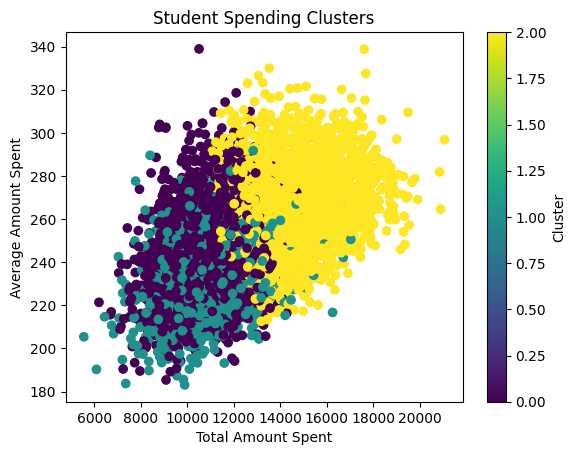

In [ ]:
# Visualize clusters using TotalAmount and AvgAmount
plt.scatter(student_summary['TotalAmount'], student_summary['AvgAmount'], c=student_summary['Cluster'], cmap='viridis')
plt.xlabel('Total Amount Spent')
plt.ylabel('Average Amount Spent')
plt.title('Student Spending Clusters')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Save the clustered data to a CSV file
output_path = 'student_financial_clusters.csv'
student_summary.to_csv(output_path, index=False)

print(f"Clustered data saved as '{output_path}'.")


Clustered data saved as 'student_financial_clusters.csv'.


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = student_summary.drop(['StudentID', 'Cluster'], axis=1)  # Exclude ID and target
y = student_summary['Cluster']  # Target is the cluster assignment

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (7999, 7)
Testing data shape: (2000, 7)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.9695

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       801
           1       0.95      0.95      0.95       316
           2       0.98      0.98      0.98       883

    accuracy                           0.97      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.97      0.97      0.97      2000



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Retrieve the best model from grid search
optimized_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred_optimized = optimized_rf_model.predict(X_test)

# Evaluate the optimized model
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nClassification Report:\n", classification_report(y_test, y_pred_optimized))


Optimized Model Accuracy: 0.971

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       801
           1       0.95      0.95      0.95       316
           2       0.98      0.98      0.98       883

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [ ]:
import joblib

# Save the optimized model for future use
joblib.dump(optimized_rf_model, 'optimized_rf_model.pkl')
print("Optimized model saved as 'optimized_rf_model.pkl'.")


Optimized model saved as 'optimized_rf_model.pkl'.


<ipython-input-16-a90b9957a1c7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_spending.index, y=category_spending.values, palette='viridis')


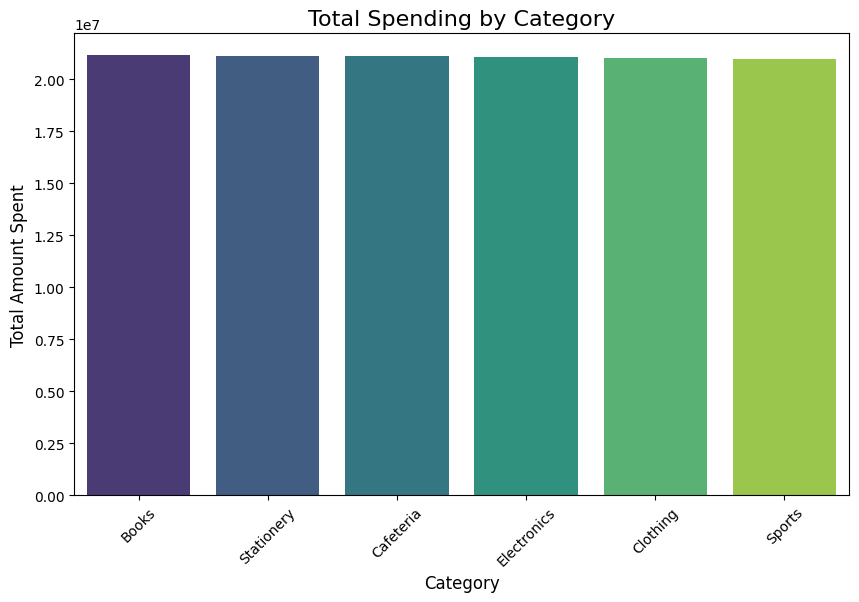

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate total spending per category
category_spending = data.groupby('Category')['Amount'].sum().sort_values(ascending=False)

# Bar plot for category-wise spending
plt.figure(figsize=(10, 6))
sns.barplot(x=category_spending.index, y=category_spending.values, palette='viridis')
plt.title('Total Spending by Category', fontsize=16)
plt.ylabel('Total Amount Spent', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45)
plt.show()


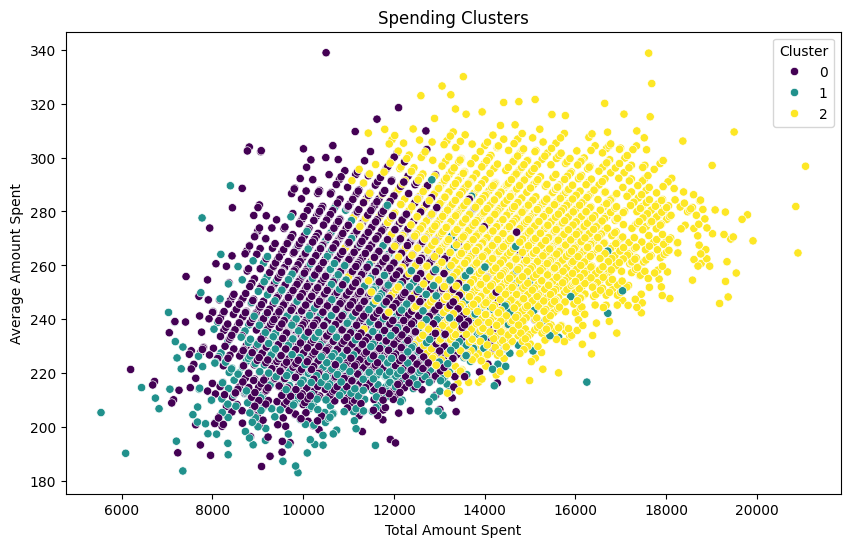

In [ ]:
# Scatter plot of clusters using TotalAmount and AvgAmount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=student_summary, x='TotalAmount', y='AvgAmount', hue='Cluster', palette='viridis')
plt.title('Spending Clusters')
plt.xlabel('Total Amount Spent')
plt.ylabel('Average Amount Spent')
plt.legend(title='Cluster')
plt.show()


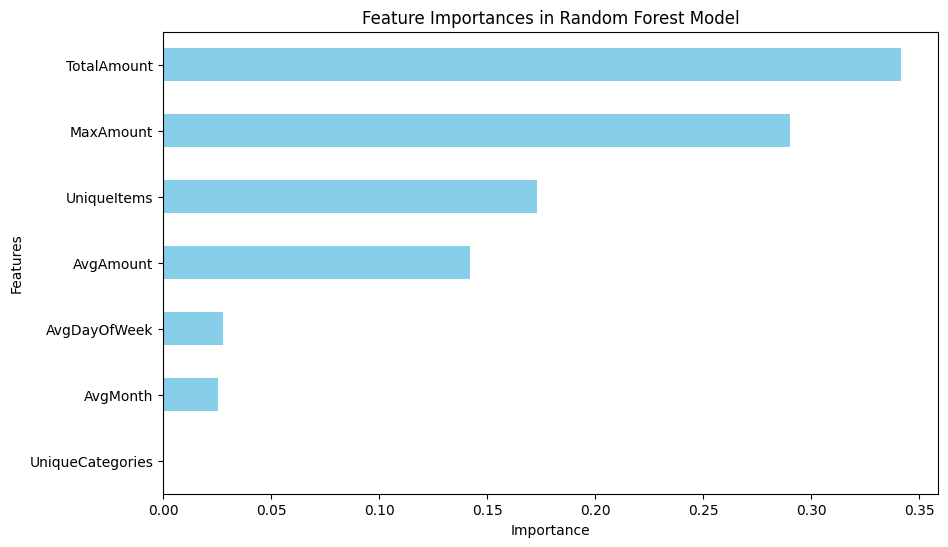

In [ ]:
import numpy as np

# Extract feature importances from the trained Random Forest model
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


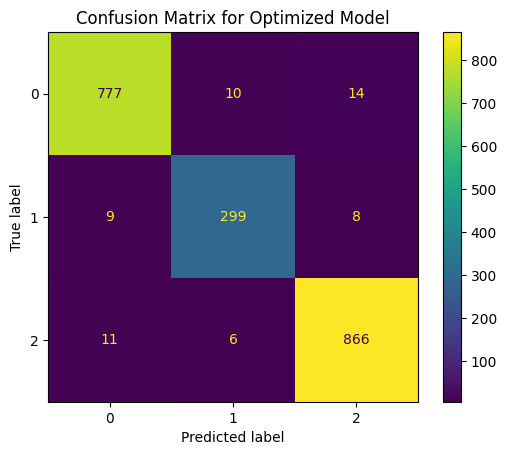

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix for the optimized model
ConfusionMatrixDisplay.from_estimator(
    optimized_rf_model, X_test, y_test, cmap='viridis', xticks_rotation='horizontal'
)
plt.title('Confusion Matrix for Optimized Model')
plt.show()


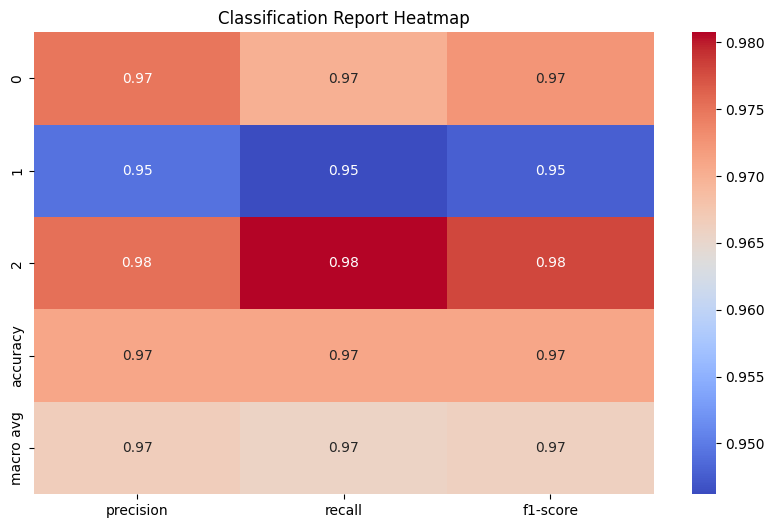

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report dictionary
report = classification_report(y_test, y_pred_optimized, output_dict=True)

# Convert to DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Plot heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()


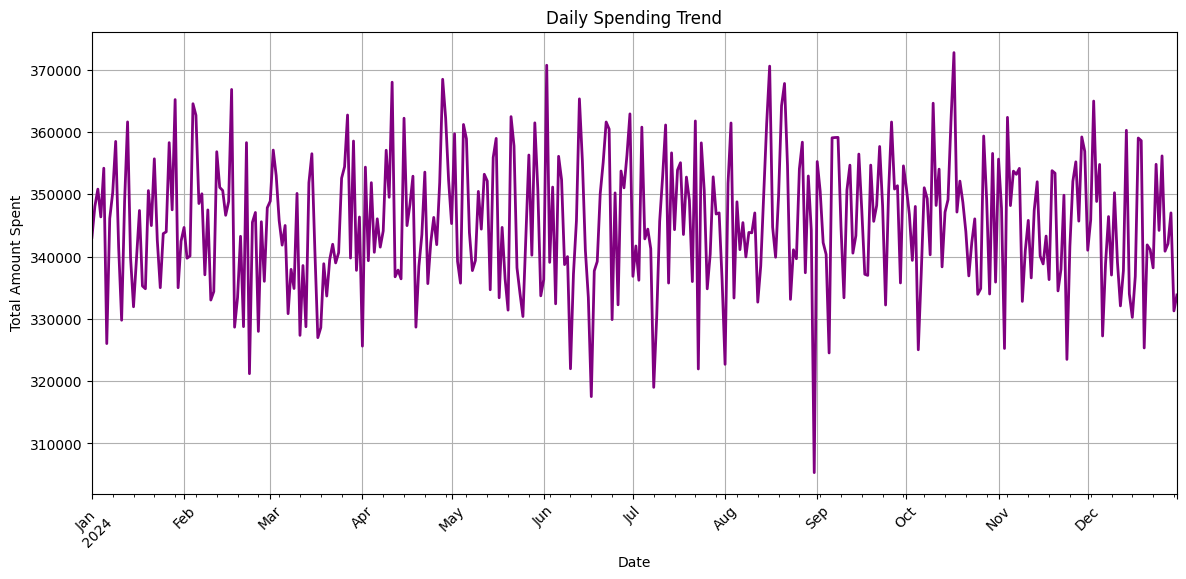

In [ ]:
# Aggregate total spending by date
daily_spending = data.groupby('Date')['Amount'].sum()

# Plot the spending trend
plt.figure(figsize=(14, 6))
daily_spending.plot(color='purple', linewidth=2)
plt.title('Daily Spending Trend')
plt.ylabel('Total Amount Spent')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


In [ ]:
# Define the hyperparameter search space
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],   # Number of trees in the forest
    'max_depth': [10, 20, 30, None],            # Maximum depth of trees
    'min_samples_split': [2, 5, 10],            # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]                  # Whether bootstrap samples are used
}


In [ ]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=20,              # Number of random parameter combinations to try
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1               # Use all available processors
)

# Fit RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best Cross-Validation Score: 0.9709962173708031


In [ ]:
# Retrieve the best model from RandomizedSearchCV
optimized_rf_model = random_search.best_estimator_

# Predict on the test set
y_pred_optimized = optimized_rf_model.predict(X_test)

# Evaluate the optimized model
print("Optimized Model Accuracy on Test Set:", accuracy_score(y_test, y_pred_optimized))
print("\nClassification Report for Optimized Model:\n", classification_report(y_test, y_pred_optimized))


Optimized Model Accuracy on Test Set: 0.971

Classification Report for Optimized Model:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       801
           1       0.95      0.95      0.95       316
           2       0.97      0.98      0.98       883

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [ ]:
import joblib

# Save the optimized model
joblib.dump(optimized_rf_model, 'optimized_rf_model_randomized.pkl')
print("Optimized model saved as 'optimized_rf_model_randomized.pkl'.")


Optimized model saved as 'optimized_rf_model_randomized.pkl'.
